<a href="https://colab.research.google.com/github/Panchagiri-vidyasri/data-analysis-using-python_2116/blob/main/daup_audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kinguistics/heartbeat-sounds")

print("Path to dataset files:", path)

100%|██████████| 110M/110M [00:01<00:00, 58.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kinguistics/heartbeat-sounds/versions/1


In [2]:
import os

# Path to the dataset directory
dataset_path = "/root/.cache/kagglehub/datasets/kinguistics/heartbeat-sounds/versions/1"

# List the files in the dataset directory
files_in_directory = os.listdir(dataset_path)
print(files_in_directory)

['set_b.csv', 'set_b', 'set_a', 'set_a_timing.csv', 'set_a.csv']


In [3]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [4]:
dataset_path = "/root/.cache/kagglehub/datasets/kinguistics/heartbeat-sounds/versions/1"

In [5]:
heartbeat_dirs = os.listdir(dataset_path)

In [7]:
input_folder = "/root/.cache/kagglehub/datasets/kinguistics/heartbeat-sounds/versions/1"  # Change path
output_folder = "/content/drive/MyDrive/dataset_balanced"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for file in os.listdir(input_folder):
    if file.endswith(".wav"):
        file_path = os.path.join(input_folder, file)
        audio, sr = librosa.load(file_path, sr=None)

        # Add noise
        noisy_audio = add_noise(audio)

        # Save the new audio file
        output_path = os.path.join(output_folder, "noisy_" + file)
        sf.write(output_path, noisy_audio, sr)

print("Dataset augmentation complete!")

Dataset augmentation complete!


In [8]:
features = []
labels = []

# Extract features for heartbeat sounds and labels
for heartbeat_type in heartbeat_dirs:
    heartbeat_folder_path = os.path.join(dataset_path, heartbeat_type)

    if os.path.isdir(heartbeat_folder_path):
        audio_files_in_dir = os.listdir(heartbeat_folder_path)

        for audio_file in audio_files_in_dir:
            if audio_file.endswith('.wav'):
                audio_file_path = os.path.join(heartbeat_folder_path, audio_file)

                # Load the audio file
                audio, sr = librosa.load(audio_file_path, sr=None)

                # Extract MFCC features (without taking the mean)
                mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)

                # Append the MFCC features and corresponding labels (heartbeat_type as label)
                features.append(mfcc)
                labels.append(heartbeat_type)


In [9]:
# Convert labels to standard Python strings (if needed)
labels = [str(label) for label in labels]

# Pad MFCC features to have the same length
max_len = max(feature.shape[1] for feature in features)  # Find the maximum length
features_padded = [np.pad(feature, ((0, 0), (0, max_len - feature.shape[1])), mode='constant') for feature in features]

# Convert features and labels to numpy arrays
features = np.array(features_padded)  # Use the padded features
labels = np.array(labels)

# Check class distribution
class_distribution = Counter(labels)
print("Class Distribution:", class_distribution)

Class Distribution: Counter({np.str_('set_b'): 656, np.str_('set_a'): 176})


In [10]:
# ... (previous code for feature extraction and padding)

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Assuming 'features' and 'labels' are your data and target variables
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)  # Adjust test_size and random_state as needed

# Encode labels using LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)


# Reshape data for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))  # Reshape for LSTM
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))  # Reshape for LSTM

print("Train data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

# ... (rest of your code for model building and training)

Train data shape: (665, 13, 776)
Test data shape: (167, 13, 776)


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

# Build the LSTM model
model = Sequential()

# First LSTM layer
model.add(LSTM(units=128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(units=128, activation='relu', return_sequences=True))  # Added return_sequences=True
model.add(Dropout(0.2))

# Third LSTM layer
model.add(LSTM(units=128, activation='relu'))  # No need for return_sequences as it's the last LSTM layer
model.add(Dropout(0.2))

# Dense output layer with softmax activation (since it's multi-class classification)
# Get the number of unique labels
num_classes = len(np.unique(y_train))  # Use y_train to get unique labels

# Replace labels_encoded with num_classes
model.add(Dense(units=num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 13, 128)             │         463,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 13, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 13, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 13, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 726,786 (2.77 MB)

 Trainable params: 726,786 (2.77 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization

# Define the LSTM Model
model = Sequential()

# 🔹 **1st LSTM Layer**
model.add(LSTM(units=256, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# 🔹 **2nd LSTM Layer**
model.add(LSTM(units=256, activation='relu', return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# 🔹 **3rd LSTM Layer**
model.add(LSTM(units=128, activation='relu', return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# 🔹 **4th LSTM Layer**
model.add(LSTM(units=128, activation='relu', return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# 🔹 **5th LSTM Layer**
model.add(LSTM(units=64, activation='relu', return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# 🔹 **6th LSTM Layer**
model.add(LSTM(units=64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# 🔹 Fully Connected Layers
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.2))

# 🔹 Output Layer (softmax for multi-class classification)
num_classes = len(np.unique(y_train))  # Get number of unique labels
model.add(Dense(units=num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 13, 256)             │       1,057,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 13, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 13, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 13, 256)             │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 13, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 13, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 13, 128)             │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 13, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 13, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 13, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 13, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 13, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 13, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 13, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 13, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,004,130 (7.65 MB)

 Trainable params: 2,002,338 (7.64 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [14]:
# Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 451ms/step - accuracy: 0.9974 - loss: 0.0123 - val_accuracy: 0.9641 - val_loss: 0.2553
Epoch 2/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 290ms/step - accuracy: 0.9879 - loss: 0.0372 - val_accuracy: 0.8443 - val_loss: 0.4488
Epoch 3/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 397ms/step - accuracy: 0.9943 - loss: 0.0207 - val_accuracy: 0.7485 - val_loss: 0.6874
Epoch 4/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 286ms/step - accuracy: 0.9944 - loss: 0.0161 - val_accuracy: 0.7665 - val_loss: 0.5691
Epoch 5/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 284ms/step - accuracy: 0.9929 - loss: 0.0640 - val_accuracy: 0.8503 - val_loss: 0.4512
Epoch 6/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 362ms/step - accuracy: 0.9995 - loss: 0.0045 - val_accuracy: 0.8922 - val_loss: 0.3867
Epoch 7/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 294ms/step - accuracy: 0.9932 - loss: 0.0369 - val_accuracy: 0.9281 - val_loss: 0.2972
Epoch 8/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 369ms/step - accuracy: 0.9917 - loss: 0.0334 - val_accuracy: 0.

In [15]:
# Evaluate the model on the test data
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

# Convert label_encoder.classes_ to a list of strings
target_names = [str(cls) for cls in label_encoder.classes_]

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_names)) # Use target_names instead of label_encoder.classes_

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 345ms/step
Classification Report:
              precision    recall  f1-score   support

       set_a       1.00      0.88      0.94        43
       set_b       0.96      1.00      0.98       124

    accuracy                           0.97       167
   macro avg       0.98      0.94      0.96       167
weighted avg       0.97      0.97      0.97       167



Confusion Matrix:


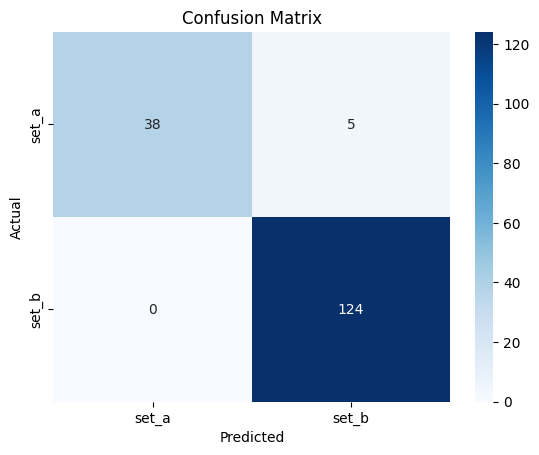

In [16]:
# Print confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

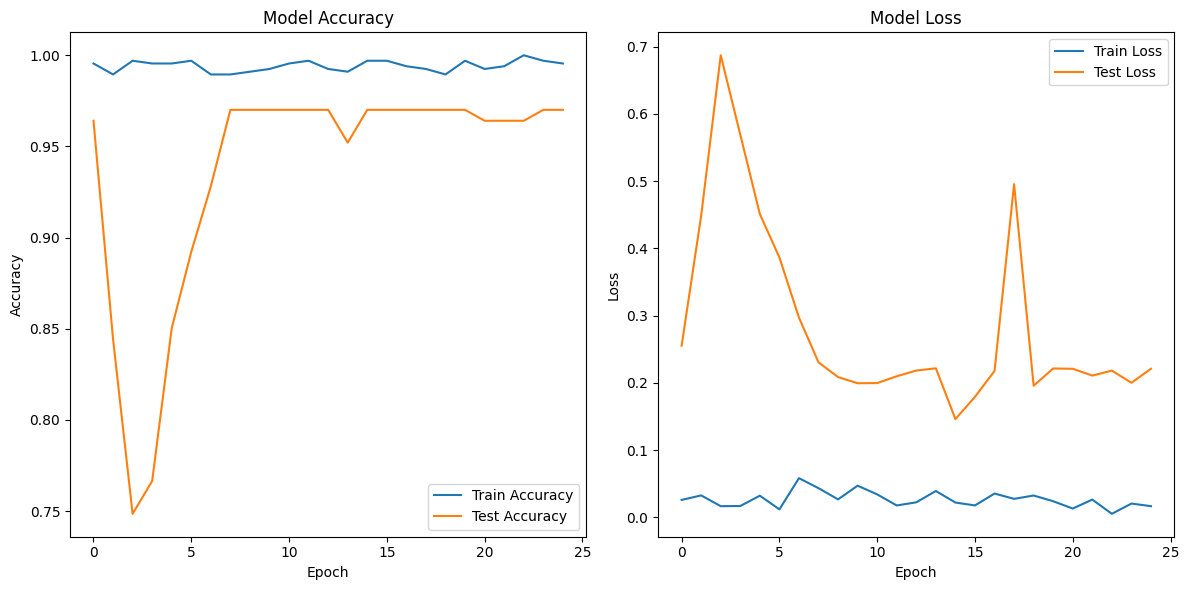

In [17]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
# Z-Test
from statsmodels.stats.weightstats import ztest
from scipy.stats import ttest_ind
from scipy.stats import ttest_ind, f_oneway
sample1 = np.random.normal(50, 10, 100)
sample2 = np.random.normal(52, 10, 100)
z_stat, p_value = ztest(sample1, sample2)
print(f"Z-Test: Z-stat = {z_stat:.2f}, p-value = {p_value:.4f}")

# T-Test
t_stat, p_ttest = ttest_ind(sample1, sample2)
print(f"T-Test: T-stat = {t_stat:.2f}, p-value = {p_ttest:.4f}")

# ANOVA Test
sample3 = np.random.normal(48, 10, 100)
anova_stat, p_anova = f_oneway(sample1, sample2, sample3)
print(f"ANOVA Test: F-stat = {anova_stat:.2f}, p-value = {p_anova:.4f}")



Z-Test: Z-stat = -2.13, p-value = 0.0328
T-Test: T-stat = -2.13, p-value = 0.0341
ANOVA Test: F-stat = 3.25, p-value = 0.0402
